In [1]:
import numpy as np
import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/CS180 Project 4'

/content/drive/MyDrive/CS180 Project 4


#### 2.1: Create Rays from Cameras

In [4]:
def transform(c2w, x_c):
    #print(c2w.shape, x_c.shape)
    if len(c2w.shape) > 2:
        return np.einsum("nij,nj->ni", c2w, x_c)
    return (c2w @ x_c.T).T

In [5]:
def pixel_to_camera(K, uv, s):
    if len(uv.shape) > 1:
        num_points = len(uv)
    else:
        num_points = 1
    uv_cols = uv.T
    uv_cols_homogeneous = np.vstack((uv_cols, np.ones(num_points)))
    uv_cols_homogeneous = (uv_cols_homogeneous.T * s).T
    res = np.linalg.inv(K) @ uv_cols_homogeneous
    return res.T

#### 2.2: Sampling

In [6]:
def pixel_to_ray(K, c2w, uv):
    if len(uv.shape) > 1:
        num_points = len(uv)
    else:
        num_points = 1
    camera_coords = pixel_to_camera(K, uv, 1)
    camera_coords_cols = camera_coords.T
    camera_coords_cols_homogeneous = np.vstack((camera_coords_cols, np.ones(num_points)))
    camera_coords_homogeneous = camera_coords_cols_homogeneous.T
    #print(camera_coords_homogeneous.shape)
    world_coords_homogeneous = transform(c2w, camera_coords_homogeneous)
    world_coords = world_coords_homogeneous[:, :3] / world_coords_homogeneous[:, 3][:, None]
    if len(c2w.shape) > 2:
        r_o = c2w[:,:3,3]
    else:
        r_o = np.broadcast_to(c2w[:3,3][None,:], (num_points, 3))
    directions = world_coords - r_o
    magnitudes = np.linalg.norm(directions, axis=1)
    r_b = directions / magnitudes[:, None]
    return r_o, r_b

In [7]:
def sample_rays(images_train, c2ws_train, K, N_sample=10000):
    N_train, H, W, _ = images_train.shape
    image_indices = np.random.choice(N_train, size=(N_sample, 1))
    row_indices = np.random.choice(H, size=(N_sample, 1))
    col_indices = np.random.choice(W, size=(N_sample, 1))

    output = images_train[image_indices, row_indices, col_indices].reshape((N_sample, 3))
    uv = np.hstack((col_indices + 0.5, row_indices + 0.5))
    c2ws = c2ws_train[image_indices.reshape((N_sample))]

    r_o, r_b = pixel_to_ray(K, c2ws, uv)

    return r_o, r_b, output

#### 2.3: Putting the Dataloading All Together

In [8]:
def sample_along_rays(r_o, r_b, near, far, num_samples=32, perturb=True):
    num_rays = len(r_o)
    t = np.linspace(near, far, num_samples)
    t = np.tile(t, (num_rays, 1))
    if perturb:
        t = t + (np.random.rand(*t.shape) * (far - near) / (num_samples - 1))

    changes_vectors = np.einsum("ni,nj->nji", r_b, t)
    resulting_samples = r_o[:,None,:] + changes_vectors

    return resulting_samples

In [9]:
def flatten_and_positional_embedding(ray_samples, r_b, L_pos=10, L_dir=4):
    B, num_samples, _ = ray_samples.shape

    # Flatten and add positional embeddings to ray samples (positions)
    ray_samples_flattened = ray_samples.reshape((B * num_samples, 3))
    x_pos, y_pos, z_pos = ray_samples_flattened[:, 0], ray_samples_flattened[:, 1], ray_samples_flattened[:, 2]
    pos_coefficients_vector = np.array([2 ** exp for exp in range(L_pos)]) * np.pi
    sinusoidal_inputs_x = np.outer(x_pos, pos_coefficients_vector)
    sinusoidal_inputs_y = np.outer(y_pos, pos_coefficients_vector)
    sinusoidal_inputs_z = np.outer(z_pos, pos_coefficients_vector)

    sin_x = np.sin(sinusoidal_inputs_x)
    cos_x = np.cos(sinusoidal_inputs_x)
    sin_y = np.sin(sinusoidal_inputs_y)
    cos_y = np.cos(sinusoidal_inputs_y)
    sin_z = np.sin(sinusoidal_inputs_z)
    cos_z = np.cos(sinusoidal_inputs_z)

    samples_with_pe = res = np.hstack((sin_x, cos_x, sin_y, cos_y, sin_z, cos_z, ray_samples_flattened))#np.reshape(x_pos, (B*num_samples, 1)), np.reshape(y_pos, (B*num_samples, 1)), np.reshape(z_pos, (B*num_samples, 1))))

    # Expand (2) and add positional embeddings (1) to ray directions
    r_b_use = -r_b
    x_dir, y_dir, z_dir = r_b_use[:, 0], r_b_use[:, 1], r_b_use[:, 2]
    dir_coefficients_vector = np.array([2 ** exp for exp in range(L_dir)]) * np.pi
    sinusoidal_inputs_x = np.outer(x_dir, dir_coefficients_vector)
    sinusoidal_inputs_y = np.outer(y_dir, dir_coefficients_vector)
    sinusoidal_inputs_z = np.outer(z_dir, dir_coefficients_vector)

    sin_x = np.sin(sinusoidal_inputs_x)
    cos_x = np.cos(sinusoidal_inputs_x)
    sin_y = np.sin(sinusoidal_inputs_y)
    cos_y = np.cos(sinusoidal_inputs_y)
    sin_z = np.sin(sinusoidal_inputs_z)
    cos_z = np.cos(sinusoidal_inputs_z)

    directions_with_pe = np.hstack((sin_x, cos_x, sin_y, cos_y, sin_z, cos_z, r_b_use))
    directions_with_pe = np.repeat(directions_with_pe, repeats=num_samples, axis=0)

    return samples_with_pe, directions_with_pe

##### Visualizations

In [ ]:
class RaysData:
    def __init__(self, images_train, K, c2ws_train):
        self.images_train = images_train
        self.K = K
        self.c2ws_train = c2ws_train
        self.H, self.W = images_train.shape[1:3]
        self.N = len(images_train)
        I, Y, X = np.meshgrid(np.arange(self.N), np.arange(self.H), np.arange(self.W), indexing="ij")
        tot_indices = np.stack((I, X, Y), axis=-1).reshape(-1, 3)
        self.uvs = tot_indices[:, 1:]
        uvs_use = self.uvs + 0.5
        self.pixels = images_train[tot_indices[:, 0], tot_indices[:, 2], tot_indices[:, 1], :]
        c2ws_use = np.broadcast_to(c2ws_train[:, None, None, :, :], (self.N, self.H, self.W, 4, 4)).reshape((self.N * self.H * self.W, 4, 4))
        self.rays_o, self.rays_d = pixel_to_ray(K, c2ws_use, uvs_use)

    def sample_rays(self, B):
        random_indices = np.random.choice(self.H * self.W, size=B)
        return self.rays_o[random_indices, :], self.rays_b[random_indices, :], self.pixels[random_indices, :]
        #return sample_rays(self.images_train, self.c2ws_train, self.K, B)

In [ ]:
data = np.load('data/2/lego_200x200.npz')

In [ ]:
data

NpzFile 'data/lego_200x200.npz' with keys: images_train, images_val, c2ws_train, c2ws_val, c2ws_test...

In [ ]:
H, W = data["images_train"].shape[1:3]

In [ ]:
K = np.array([[data["focal"], 0.00000000e+00, W / 2.0],
       [0.00000000e+00, data["focal"], H / 2.0],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
r_o, r_b, output = sample_rays(data['images_train'], data['c2ws_train'], K)

(10000, 4)


In [ ]:
import viser, time  # pip install viser
import numpy as np

#images_train, c2ws_train = data["images_train"], data["c2ws_train"]

# --- You Need to Implement These ------
rays_o, rays_d, pixels = sample_rays(images_train, c2ws_train, K, 100) # Should expect (B, 3)
points = sample_along_rays(rays_o, rays_d, 2.0, 6.0, perturb=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

(100, 4)


╭────── viser (listening *:8086) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8086   │
│   Websocket │ ws://localhost:8086     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

/Users/lencini/Applications/anaconda3/envs/cs180-proj1/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


(viser) Generated share URL (expires in 24 hours, max 16 clients): https://histogram-best.share.viser.studio

/var/folders/_g/tc7wxrms1_s6_rj872mkhg9w0000gn/T/ipykernel_3716/1365427998.py:14: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/var/folders/_g/tc7wxrms1_s6_rj872mkhg9w0000gn/T/ipykernel_3716/1365427998.py:24: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/var/folders/_g/tc7wxrms1_s6_rj872mkhg9w0000gn/T/ipykernel_3716/1365427998.py:27: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


(viser) Connection opened (0, 1 total), 608 persistent messages

(viser) Connection closed (0, 0 total)

(viser) Connection opened (1, 1 total), 608 persistent messages

(viser) Disconnected from share URL

KeyboardInterrupt: 

In [ ]:
server.stop()

(viser) Connection closed (0, 0 total)

(viser) Server stopped

In [ ]:
dataset = RaysData(images_train, K, c2ws_train)

(4000000, 4)


In [ ]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
# indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
indices_x = np.random.randint(low=100, high=200, size=100)
indices_y = np.random.randint(low=0, high=100, size=100)
indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = sample_along_rays(data["rays_o"], data["rays_d"], 2.0, 6.0, perturb=True)
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)

while True:
  time.sleep(0.1)

(4000000, 4)


╭────── viser (listening *:8086) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8086   │
│   Websocket │ ws://localhost:8086     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

/Users/lencini/Applications/anaconda3/envs/cs180-proj1/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


(viser) Generated share URL (expires in 24 hours, max 16 clients): https://u-close-up.share.viser.studio

/var/folders/_g/tc7wxrms1_s6_rj872mkhg9w0000gn/T/ipykernel_3716/4182720778.py:29: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/var/folders/_g/tc7wxrms1_s6_rj872mkhg9w0000gn/T/ipykernel_3716/4182720778.py:40: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/var/folders/_g/tc7wxrms1_s6_rj872mkhg9w0000gn/T/ipykernel_3716/4182720778.py:43: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


(viser) Connection opened (0, 1 total), 608 persistent messages

(viser) Disconnected from share URL

KeyboardInterrupt: 

In [ ]:
server.stop()

(viser) Connection closed (0, 0 total)

(viser) Server stopped

#### Part 2.4: Neural Radiance Field

In [10]:
class NeRF(nn.Module):
    def __init__(self, L_pos=10, L_dir=4, W=256):
        super().__init__()
        self.L_pos = L_pos
        self.L_dir = L_dir
        self.W = W

        # Common embeddings
        self.linear1 = nn.Linear(6*L_pos+3,W)
        self.linear2 = nn.Linear(W,W)
        self.linear3 = nn.Linear(W,W)
        self.linear4 = nn.Linear(W,W)
        self.linear5 = nn.Linear(W+6*L_pos+3,W)
        self.linear6 = nn.Linear(W,W)
        self.linear7 = nn.Linear(W,W)
        self.linear8 = nn.Linear(W,W)

        # Upper Branch
        self.linear_density = nn.Linear(W,1)

        # Lower Branch
        self.linear1_color = nn.Linear(W, W)
        self.linear2_color = nn.Linear(W+6*L_dir+3,W//2)
        self.linear3_color = nn.Linear(W//2,3)

        # Utils
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, r_d):
        # Calculate embeddings
        hidden = self.linear1(x)
        hidden = self.relu(hidden)
        hidden = self.linear2(hidden)
        hidden = self.relu(hidden)
        hidden = self.linear3(hidden)
        hidden = self.relu(hidden)
        hidden = self.linear4(hidden)
        hidden = self.relu(hidden)
        hidden = torch.cat((hidden, x), 1)
        hidden = self.linear5(hidden)
        hidden = self.relu(hidden)
        hidden = self.linear6(hidden)
        hidden = self.relu(hidden)
        hidden = self.linear7(hidden)
        hidden = self.relu(hidden)
        embedding = self.linear8(hidden)

        # Calculate densities
        density_hidden = self.linear_density(embedding)
        density = self.relu(density_hidden)

        # Calculate the colors
        color_hidden = self.linear1_color(embedding)
        color_hidden = torch.cat((color_hidden, r_d), 1)
        color_hidden = self.linear2_color(color_hidden)
        color_hidden = self.relu(color_hidden)
        color_hidden = self.linear3_color(color_hidden)
        rgb = self.sigmoid(color_hidden)

        return density, rgb

#### Part 2.5: Volume Rendering

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
def volrend(sigmas, rgbs, step_size):
    num_points, num_samples, num_channels = rgbs.shape
    exponents = -sigmas * step_size
    exponents_summed = torch.cumsum(exponents, dim=1)
    exponents_transmittance = torch.hstack((torch.zeros((num_points, 1, 1), device=device), exponents_summed[:, :num_samples - 1, :]))
    transmittance = torch.exp(exponents_transmittance)
    hit_probabilities = 1 - torch.exp(exponents)
    tot_weight = transmittance * hit_probabilities
    weighted_colors = tot_weight * rgbs
    res_colors = torch.sum(weighted_colors, dim=1)
    return res_colors

In [ ]:
''' torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1), device=device)
rgbs = torch.rand((10, 64, 3), device=device)
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ], device=device) '''
#assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4) # may error due to differing versions

' torch.manual_seed(42)\nsigmas = torch.rand((10, 64, 1), device=device)\nrgbs = torch.rand((10, 64, 3), device=device)\nstep_size = (6.0 - 2.0) / 64\nrendered_colors = volrend(sigmas, rgbs, step_size)\n\ncorrect = torch.tensor([\n    [0.5006, 0.3728, 0.4728],\n    [0.4322, 0.3559, 0.4134],\n    [0.4027, 0.4394, 0.4610],\n    [0.4514, 0.3829, 0.4196],\n    [0.4002, 0.4599, 0.4103],\n    [0.4471, 0.4044, 0.4069],\n    [0.4285, 0.4072, 0.3777],\n    [0.4152, 0.4190, 0.4361],\n    [0.4051, 0.3651, 0.3969],\n    [0.3253, 0.3587, 0.4215]\n  ], device=device) '

In [13]:
def render_one_image(model, c2w, H, W, K, near=2.0, far=6.0, num_samples=32):
    # render an image using model.
    L_pos = model.L_pos
    L_dir = model.L_dir
    image_rows = []
    for v in range(H):
        uvs = np.array([[u + 0.5, v + 0.5] for u in range(W)])
        r_o, r_b = pixel_to_ray(K, c2w, uvs)
        position_samples = sample_along_rays(r_o, r_b, near, far, num_samples, perturb=False)
        pos_inputs, dir_inputs = flatten_and_positional_embedding(position_samples, r_b, L_pos, L_dir)
        pos_inputs, dir_inputs = torch.from_numpy(pos_inputs.astype(np.float32)).to(device), torch.from_numpy(dir_inputs.astype(np.float32)).to(device)
        sigmas, rgbs = model(pos_inputs, dir_inputs)
        sigmas = sigmas.reshape((W, num_samples, 1))
        rgbs = rgbs.reshape((W, num_samples, 3))
        step_size = (far - near) / (num_samples - 1)
        rendered_colors = volrend(sigmas, rgbs, step_size)
        rendered_colors = rendered_colors.cpu().numpy()
        image_rows.append(rendered_colors.reshape(1, W, 3))
    return np.vstack(tuple(image_rows))
    # Generate each uv row by row (+0.5).
    # get r_o and r_b
    # get samples
    # Feed samples and r_b to flatten_and_positional_embedding
    # Feed to model
    # volrend
    # append
    # (outside of loop) stack together.

##### Test rendering an image

In [ ]:
data = np.load('data/2/lego_200x200.npz')
images_train, c2ws_train = data["images_train"], data["c2ws_train"]
images_val, c2ws_val = data["images_val"], data["c2ws_val"]

In [ ]:
images_train = (images_train / 255).astype(np.float32)
images_val = (images_val / 255).astype(np.float32)

In [ ]:
image_H, image_W = data["images_train"].shape[1:3]

In [ ]:
K = np.array([[data["focal"], 0.00000000e+00, image_W / 2.0],
       [0.00000000e+00, data["focal"], image_H / 2.0],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
model = NeRF()
model.to(device)

NeRF(
  (linear1): Linear(in_features=63, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=319, out_features=256, bias=True)
  (linear6): Linear(in_features=256, out_features=256, bias=True)
  (linear7): Linear(in_features=256, out_features=256, bias=True)
  (linear8): Linear(in_features=256, out_features=256, bias=True)
  (linear_density): Linear(in_features=256, out_features=1, bias=True)
  (linear1_color): Linear(in_features=256, out_features=256, bias=True)
  (linear2_color): Linear(in_features=319, out_features=128, bias=True)
  (linear3_color): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
image_H, image_W = data["images_train"].shape[1:3]

In [ ]:
K = np.array([[data["focal"], 0.00000000e+00, image_W / 2.0],
       [0.00000000e+00, data["focal"], image_H / 2.0],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
with torch.no_grad():
    res = render_one_image(model, data['c2ws_test'][0], image_H, image_W, K)

/tmp/ipython-input-4211006476.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(res)
/usr/local/lib/python3.12/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


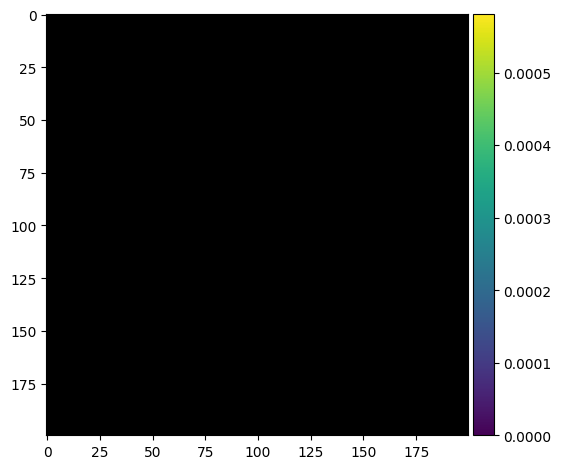

In [ ]:
skio.imshow(res)

##### Train

In [ ]:
# Configurations
num_iters = 3000
N = 10000
L_pos = 10
L_dir = 4
W = 256
lr = 5e-4
near = 2.0 # TUNE, maybe 0.10 for mine
far = 6.0 # TUNE, maybe 0.50 for mine
num_samples = 64 # tune?

In [ ]:
model = NeRF(L_pos, L_dir, W)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

iteration 0: training PSNR is 10.745995185126072
iteration 0: validation PSNR is 12.511490530602053
iteration 100: training PSNR is 17.277827273024645
iteration 100: validation PSNR is 17.745868503695203
iteration 200: training PSNR is 19.08935529175384
iteration 200: validation PSNR is 19.655285779549082
iteration 300: training PSNR is 19.9658941079134
iteration 300: validation PSNR is 20.322612837102426
iteration 400: training PSNR is 20.295939574793664
iteration 400: validation PSNR is 20.909511879494666
iteration 500: training PSNR is 21.01780199541867
iteration 500: validation PSNR is 21.529618730895745
iteration 600: training PSNR is 21.360367138090286
iteration 600: validation PSNR is 22.000940231246823
iteration 700: training PSNR is 21.96001831896346
iteration 700: validation PSNR is 22.375476743791186
iteration 800: training PSNR is 22.149667299434235
iteration 800: validation PSNR is 22.835246391338455
iteration 900: training PSNR is 22.210507557403897
iteration 900: validat

KeyboardInterrupt: 

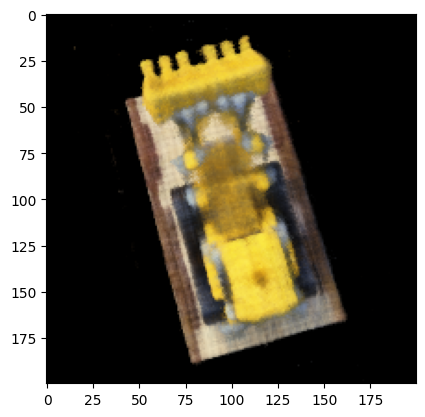

In [ ]:
train_psnrs = []
val_psnrs = []
images = []
for iter in range(num_iters):
    # Randomly sample rays and outputs
    # get the ray samples
    # transform into inputs
    # put on pytorch
    # inference
    # optimizer step
    # if iteration special, do validation images (calculate both avg psnr and record one of the images).
    optimizer.zero_grad()

    r_o, r_b, c = sample_rays(images_train, c2ws_train, K, N)
    ray_samples = sample_along_rays(r_o, r_b, near, far, num_samples, perturb=True)
    x_pe, r_b_pe = flatten_and_positional_embedding(ray_samples, r_b, L_pos, L_dir)
    x_pe, r_b_pe = torch.from_numpy(x_pe.astype(np.float32)).to(device), torch.from_numpy(r_b_pe.astype(np.float32)).to(device)
    sigmas, rgbs = model(x_pe, r_b_pe)
    sigmas = sigmas.reshape((N, num_samples, 1))
    rgbs = rgbs.reshape((N, num_samples, 3))
    step_size = (far - near) / (num_samples - 1)
    rendered_colors = volrend(sigmas, rgbs, step_size)
    ground_truth_colors = torch.from_numpy(c.astype(np.float32)).to(device)

    loss = criterion(rendered_colors, ground_truth_colors)
    loss.backward()
    optimizer.step()

    train_psnrs.append(10 * np.log10(1 / loss.item()))

    if iter % 100 != 0:
        continue

    print(f"iteration {iter}: training PSNR is {train_psnrs[-1]}")

    # Start evaluation on validation set
    mses = []
    for i in range(len(images_val)):
        with torch.no_grad():
            rendered_result = render_one_image(model, c2ws_val[i], image_H, image_W, K, near, far, num_samples)
            rendered_result_tensor, ground_truth_tensor = torch.from_numpy(rendered_result.astype(np.float32)).to(device), torch.from_numpy(images_val[i].astype(np.float32)).to(device)
            loss = criterion(rendered_result_tensor, ground_truth_tensor)
            mses.append(loss.item())
        if i == 0:
            images.append(rendered_result)
            plt.imshow(rendered_result)
    mse = np.average(np.array(mses))
    val_psnrs.append(10 * np.log10(1 / mse))
    print(f"iteration {iter}: validation PSNR is {val_psnrs[-1]}")

In [ ]:
for i in range(len(images)):
    skio.imsave(f"data/2/2.5/val_images/{i * 50}.jpg", (images[i] * 255).astype(np.uint8))

/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: data/2/2.5/val_images/0.jpg is a low contrast image
  return func(*args, **kwargs)


In [ ]:
test_images = []
for i in range(len(data["c2ws_test"])):
    with torch.no_grad():
        rendered_result = render_one_image(model, data["c2ws_test"][i], image_H, image_W, K, near, far, num_samples)
        test_images.append(rendered_result)

In [ ]:
for i in range(len(test_images)):
    skio.imsave(f"data/2/2.5/test_images/{i}.jpg", (test_images[i] * 255).astype(np.uint8))

Text(0.5, 1.0, 'Validation Set PSNR V.S. Iterations')

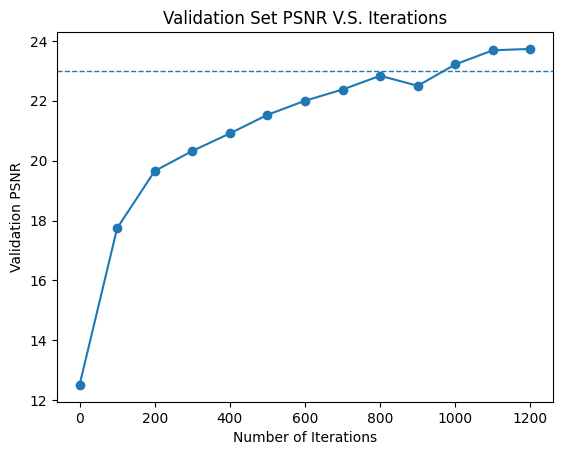

In [ ]:
plt.plot([i * 100 for i in range(13)], val_psnrs, marker='o', linestyle='-')

plt.axhline(y=23, linestyle='--', linewidth=1, label=f"desired result")

plt.xlabel("Number of Iterations")
plt.ylabel("Validation PSNR")
plt.title("Validation Set PSNR V.S. Iterations")

Got something at image 0
Got something at image 1
Got something at image 2
Got something at image 3
Got something at image 4
Got something at image 5
Got something at image 6
Got something at image 7
Got something at image 8
Got something at image 9


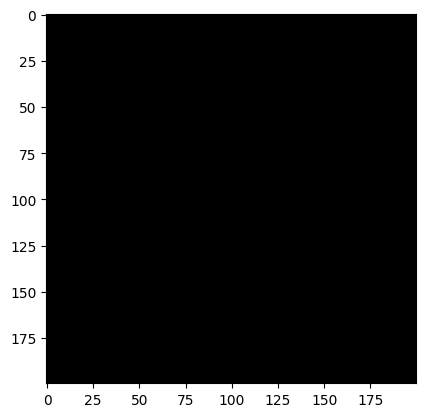

In [ ]:
mses = []
for i in range(len(images_val)):
    with torch.no_grad():
        rendered_result = render_one_image(model, c2ws_val[i], image_H, image_W, K)
        if np.max(rendered_result) > 0:
            print(f"Got something at image {i}")
        rendered_result_tensor, ground_truth_tensor = torch.from_numpy(rendered_result.astype(np.float32)).to(device), torch.from_numpy(images_val[i].astype(np.float32)).to(device)
        loss = criterion(rendered_result_tensor, ground_truth_tensor)
        mses.append(loss.item())
    if i == 0:
        images.append(rendered_result)
        plt.imshow(rendered_result)
mse = np.average(np.array(mses))

In [ ]:
10 * np.log10(1 / mse)

np.float64(11.125275916437513)

In [ ]:
np.max(rendered_result)

np.float32(0.0011971062)

##### Persimmon

In [14]:
data = np.load('data/2/persimmon_data.npz')
images_train, c2ws_train = data["images_train"], data["c2ws_train"]
images_val, c2ws_val = data["images_val"], data["c2ws_val"]

In [15]:
def downscale_images(images, downscale_factor=0.1):
    blurred_images = []
    for i in range(len(images)):
        blurred_images.append(cv2.GaussianBlur(images[i], (11, 11), 0))
    small_images = []
    for i in range(len(images)):
        small_images.append(cv2.resize(blurred_images[i], None, fx=downscale_factor, fy=downscale_factor, interpolation=cv2.INTER_AREA))
    return np.array(small_images)

In [16]:
downscale_factor = 0.1
images_train = downscale_images(images_train, downscale_factor)
images_val = downscale_images(images_val, downscale_factor)

In [17]:
images_train = (images_train / 255).astype(np.float32)[:,:,:,::-1]
images_val = (images_val / 255).astype(np.float32)[:,:,:,::-1]

In [18]:
image_H, image_W = images_train.shape[1:3]

In [19]:
K = np.array([[2.08641135e+03, 0.00000000e+00, 1.06381815e+03],
       [0.00000000e+00, 2.08357622e+03, 1.42860556e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
K *= np.array([[downscale_factor], [downscale_factor], [1]])

In [20]:
# Configurations
N = 10000
L_pos = 10
L_dir = 4
W = 256
lr = 5e-4
near = 0.05 # TUNE, maybe 0.10 for mine
far = 0.55 # TUNE, maybe 0.50 for mine
num_samples = 64 # tune?

In [21]:
model = NeRF(L_pos, L_dir, W)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
train_psnrs = []
train_losses = []
val_psnrs = []
iter = 0
while True:
    # Randomly sample rays and outputs
    # get the ray samples
    # transform into inputs
    # put on pytorch
    # inference
    # optimizer step
    # if iteration special, do validation images (calculate both avg psnr and record one of the images).
    optimizer.zero_grad()

    r_o, r_b, c = sample_rays(images_train, c2ws_train, K, N)
    ray_samples = sample_along_rays(r_o, r_b, near, far, num_samples, perturb=True)
    x_pe, r_b_pe = flatten_and_positional_embedding(ray_samples, r_b, L_pos, L_dir)
    x_pe, r_b_pe = torch.from_numpy(x_pe.astype(np.float32)).to(device), torch.from_numpy(r_b_pe.astype(np.float32)).to(device)
    sigmas, rgbs = model(x_pe, r_b_pe)
    sigmas = sigmas.reshape((N, num_samples, 1))
    rgbs = rgbs.reshape((N, num_samples, 3))
    step_size = (far - near) / (num_samples - 1)
    rendered_colors = volrend(sigmas, rgbs, step_size)
    ground_truth_colors = torch.from_numpy(c.astype(np.float32)).to(device)

    loss = criterion(rendered_colors, ground_truth_colors)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_psnrs.append(10 * np.log10(1 / loss.item()))

    iter += 1

    if iter % 50 == 0:
        print(f"iteration {iter}: training PSNR is {10 * np.log10(1 / loss.item())}")

    if iter % 100 != 0:
        continue

    # Start evaluation on validation set
    mses = []
    for i in range(len(images_val)):
        with torch.no_grad():
            rendered_result = render_one_image(model, c2ws_val[i], image_H, image_W, K, near, far, num_samples)
            rendered_result_tensor, ground_truth_tensor = torch.from_numpy(rendered_result.astype(np.float32)).to(device), torch.from_numpy(images_val[i].astype(np.float32)).to(device)
            loss = criterion(rendered_result_tensor, ground_truth_tensor)
            mses.append(loss.item())
        if i == 0:
            if iter == 50 or iter % 500 == 0:
                plt.imsave(f"data/2/2.6/persimmon1/periodic_images/{iter}.jpg", (rendered_result * 255).astype(np.uint8))
    mse = np.average(np.array(mses))
    val_psnrs.append(10 * np.log10(1 / mse))
    print(f"iteration {iter}: validation PSNR is {val_psnrs[-1]}")

    if iter % 200 == 0:
        torch.save(model.state_dict(), f"data/2/2.6/persimmon1/periodic_models/model_{iter}.pt")

iteration 50: training PSNR is 14.506022358217319
iteration 100: training PSNR is 14.66700348807499
iteration 100: validation PSNR is 14.6357555354099
iteration 150: training PSNR is 14.770178137671081
iteration 200: training PSNR is 14.97328614322264
iteration 200: validation PSNR is 14.997309235341424
iteration 250: training PSNR is 16.043163948024425
iteration 300: training PSNR is 18.357638913948772
iteration 300: validation PSNR is 18.456262477853333
iteration 350: training PSNR is 19.175049099287726
iteration 400: training PSNR is 19.7752820372151
iteration 400: validation PSNR is 20.190082640723052
iteration 450: training PSNR is 20.343694166862022
iteration 500: training PSNR is 20.7438443077694
iteration 500: validation PSNR is 21.357981427353682
iteration 550: training PSNR is 20.93238574072753
iteration 600: training PSNR is 21.17688940004333
iteration 600: validation PSNR is 21.715436927415663
iteration 650: training PSNR is 21.558333081673766
iteration 700: training PSNR i

KeyboardInterrupt: 

###### Deliverables

In [24]:
len(train_losses)

9603

Text(0.5, 1.0, 'Training MSE Loss V.S. Iteration (First 9 Iterations Omitted)')

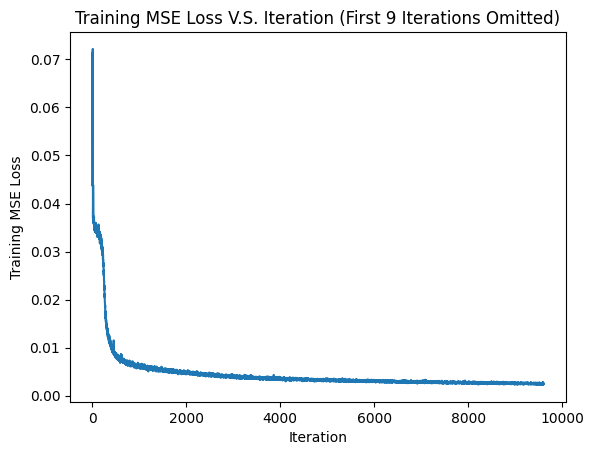

In [33]:
plt.plot(list(range(9, 9603)), train_losses[9:9603], linestyle='-')

# Labels
plt.xlabel("Iteration")
plt.ylabel("Training MSE Loss")
plt.title("Training MSE Loss V.S. Iteration (First 9 Iterations Omitted)")

Text(0.5, 1.0, 'Validation PSNR V.S. Iteration')

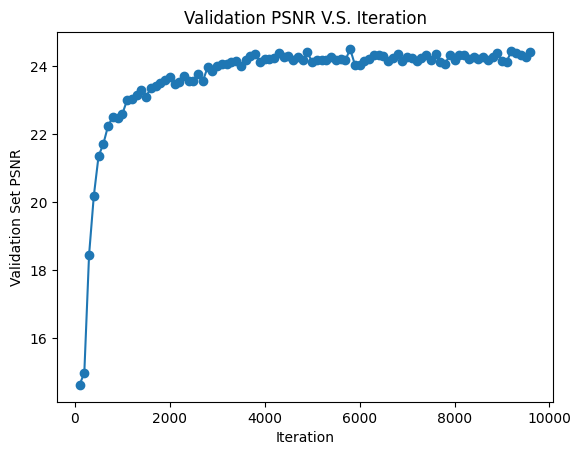

In [74]:
plt.plot(list([i * 100 for i in range(1, 97)]), val_psnrs, marker='o', linestyle='-')

# Labels
plt.xlabel("Iteration")
plt.ylabel("Validation Set PSNR")
plt.title("Validation PSNR V.S. Iteration")

In [64]:
import math
def look_at_origin(pos):
  # Camera looks towards the origin
  forward = -pos / np.linalg.norm(pos)  # Normalize the direction vector

  # Define up vector (assuming y-up)
  up = np.array([0, 0, 1])

  # Compute right vector using cross product
  right = np.cross(forward, up)
  right = right / np.linalg.norm(right)

  # Recompute up vector to ensure orthogonality
  up = np.cross(forward, right)

  # Create the camera-to-world matrix
  c2w = np.eye(4)
  c2w[:3, 0] = right
  c2w[:3, 1] = up
  c2w[:3, 2] = forward
  c2w[:3, 3] = pos

  return c2w

def rot_x(phi):
    return np.array([
        [math.cos(phi), -math.sin(phi), 0, 0],
        [math.sin(phi), math.cos(phi), 0, 0],
        [0,0,1,0],
        [0,0,0,1],
    ])

# TODO: Change start position to a good position for your scene such as
# the translation vector of one of your training camera extrinsics
START_POS = np.array([0.01617006, -0.05544711, 0.15312541])
NUM_SAMPLES = 60

frames = []
for phi in np.linspace(360., 0., NUM_SAMPLES, endpoint=False):
    c2w = look_at_origin(START_POS)
    extrinsic = rot_x(phi/180.*np.pi) @ c2w

    # Generate view for this camera pose
    # TODO: Add code for generating a view with your model from the current extrinsic
    with torch.no_grad():
        rendered_result = render_one_image(model, extrinsic, image_H, image_W, K, near, far, num_samples)
    frames.append(rendered_result)

In [69]:
for i in range(len(frames)):
    skio.imsave(f"data/2/2.6/persimmon1/angle2/{i}.jpg", (frames[i] * 255).astype(np.uint8))

In [ ]:
intermediate_model = NeRF(L_pos, L_dir, W)
state = torch.load("data/2/2.6/persimmon1/periodic_models/model_400.pt", map_location=device)
intermediate_model.load_state_dict(state, strict=True)
intermediate_model.eval()
intermediate_model.to(device)

NeRF(
  (linear1): Linear(in_features=63, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=319, out_features=256, bias=True)
  (linear6): Linear(in_features=256, out_features=256, bias=True)
  (linear7): Linear(in_features=256, out_features=256, bias=True)
  (linear8): Linear(in_features=256, out_features=256, bias=True)
  (linear_density): Linear(in_features=256, out_features=1, bias=True)
  (linear1_color): Linear(in_features=256, out_features=256, bias=True)
  (linear2_color): Linear(in_features=283, out_features=128, bias=True)
  (linear3_color): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [85]:
with torch.no_grad():
    rendered_result = render_one_image(intermediate_model, c2ws_val[0], image_H, image_W, K, near, far, num_samples)

/tmp/ipython-input-1231140513.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(rendered_result)


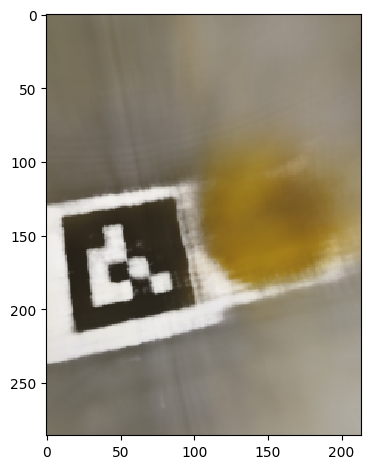

In [86]:
skio.imshow(rendered_result)

In [87]:
skio.imsave(f"data/2/2.6/persimmon1/submission_progress_images/400.jpg", (rendered_result * 255).astype(np.uint8))